In [7]:
import numpy as np
import torch
from pyronn.ct_reconstruction.geometry.geometry import Geometry
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan
from pyronn.ct_reconstruction.helpers.trajectories.circular_trajectory import circular_trajectory_2d
from pyronn.ct_reconstruction.layers.projection_2d import ParallelProjection2D

# Initializing CT geometry parameters:

# Volume parameters:
volume_size = 362  # size of the volume/image
volume_shape = [volume_size, volume_size]  # shape of the volume as [height, width]
volume_spacing = [1, 1]  # spacing between pixels in the volume

# Detector parameters:
detector_shape = [513]  # shape of the detector
detector_spacing = [1]  # spacing between detector pixels

# Trajectory parameters:
number_of_projections = 1000  # number of projections in the sinogram
angular_range = np.pi  # angular range of the trajectory (half-circle in this case)

# Create an instance of the Geometry class and initialize it with the above parameters
geometry = Geometry()
geometry.init_from_parameters(volume_shape=volume_shape, volume_spacing=volume_spacing,
                              detector_shape=detector_shape, detector_spacing=detector_spacing,
                              number_of_projections=number_of_projections, angular_range=angular_range,
                              trajectory=circular_trajectory_2d)


In [8]:
phantom = shepp_logan.shepp_logan_enhanced(volume_shape)
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()

sinogram = ParallelProjection2D().forward(phantom, **geometry)

In [9]:
def ram_lak_filter(num_detectors):
    """ Generate the RAM-LAK (Ramp) filter in the frequency domain. """
    frequencies = torch.fft.fftfreq(num_detectors)
    filter = torch.abs(frequencies)
    return filter


def FBP(sinogram, geometry):
    # Ensure sinogram is on CUDA
    sinogram = sinogram.cuda()

    # Extract dimensions
    num_channels, num_projections, num_detectors = sinogram.shape

    # Frequency domain filtering using RAM-LAK filter
    filter = ram_lak_filter(num_detectors).reshape(1, 1, -1).cuda()
    sinogram = torch.fft.ifft(torch.fft.fft(sinogram, dim=-1) * filter, dim=-1).real

    # Initialize the reconstruction volume
    reconstruction = torch.zeros((num_channels, geometry.volume_shape[0], geometry.volume_shape[1])).cuda()

    # Compute central coordinates and meshgrid once outside the loop
    center_x, center_y = geometry.volume_shape[0] // 2, geometry.volume_shape[1] // 2
    coords_x, coords_y = torch.meshgrid(torch.arange(0, geometry.volume_shape[0]).cuda() - center_x,
                                        torch.arange(0, geometry.volume_shape[1]).cuda() - center_y)

    # Compute detector index multipliers and angles once outside the loop
    detector_multiplier = (num_detectors - 1) / num_detectors
    angles = torch.linspace(0, geometry.angular_range[-1], num_projections).cuda()

    # Precompute detector indices for all angles
    detector_indices = ((coords_x * torch.cos(angles).unsqueeze(1).unsqueeze(2)
                         + coords_y * torch.sin(angles).unsqueeze(1).unsqueeze(2))
                        + num_detectors / 2) * detector_multiplier
    detector_indices = detector_indices.long().clamp(0, num_detectors - 1)

    for i in range(num_projections):
        projection = sinogram[:, i, detector_indices[i]]
        reconstruction += projection

    return reconstruction


In [10]:
import matplotlib.pyplot as plt


def plot_reconstruction(reconstruction):
    # Convert torch tensor to numpy for visualization
    if isinstance(reconstruction, torch.Tensor):
        image = reconstruction.squeeze().detach().cpu().numpy()
    else:
        image = reconstruction.squeeze()

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title("Reconstructed Image")
    plt.show()

# This function can be used to plot the reconstructed image in your notebook.


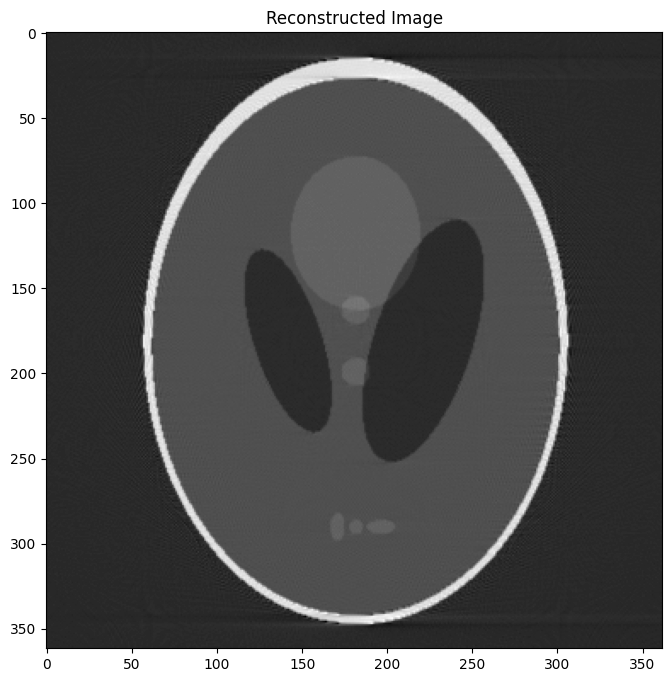

tensor([[[-14.5534, -13.5684, -19.2798,  ..., -20.7364, -14.0601, -15.2024],
         [-20.1937, -15.9982, -13.9592,  ..., -15.4116, -16.3714, -15.9021],
         [-15.3133, -16.9835, -12.5740,  ..., -16.3145, -17.6146, -17.4400],
         ...,
         [-14.1876, -15.3946, -18.4038,  ...,  -9.9151, -14.6707, -18.8554],
         [-15.4932, -19.0242, -13.8225,  ..., -20.2792, -16.9872, -16.5402],
         [-16.4482, -13.8863, -16.2302,  ..., -15.2671, -19.9589, -16.5095]]],
       device='cuda:0')

In [11]:
reconstructed_image = FBP(sinogram, geometry)
plot_reconstruction(reconstructed_image)
reconstructed_image